In [1]:
import os, sys
import numpy as np

# make sure the 'code' dir is on your path (change this):
codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import matplotlib.pyplot as plt
from matplotlib import cm

import copy
import scipy.stats

from plotting import plot_utils, load_fits, summary_plots
from utils import roi_utils, default_paths
from analyze_features import load_feature_stats

plot_utils.set_all_font_sizes(16)

In [2]:
from analyze_fits import sem_voxel_groups
sem_groups, sem_group_names = sem_voxel_groups.get_sem_voxel_groups()
n_sem_groups = len(sem_group_names)

loading from /user_data/mmhender/image_stats_gabor/model_fits/S01/semantic_discrim_raw_trnval_all/Jan-17-2023_1434_53/all_fit_params.npy

dict_keys(['subject', 'volume_space', 'voxel_mask', 'average_image_reps', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'debug', 'up_to_sess', 'single_sess', 'best_model_each_voxel', 'saved_prfs_fn', 'sem_discrim_each_axis', 'sem_corr_each_axis', 'discrim_type_list', 'n_sem_samp_each_axis', 'mean_each_sem_level', 'axes_to_do_partial', 'sem_partial_corrs', 'sem_partial_n_samp'])
loading from /user_data/mmhender/image_stats_gabor/model_fits/S02/semantic_discrim_raw_trnval_all/Jan-17-2023_1510_10/all_fit_params.npy

dict_keys(['subject', 'volume_space', 'voxel_mask', 'average_image_reps', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'debug', 'up_to_sess', 'single_sess', 'best_model_each_voxel', 'saved_prfs_fn', 'sem_discrim_each_axis', 

In [3]:
sem_group_names

['face',
 'building',
 'animate',
 'inanimate',
 'small',
 'large',
 'indoor',
 'outdoor']

#### Load everything to plot
This is an analysis correlating each voxel's beta weights with semantic category labels (no encoding model used here, just raw data)

In [7]:
subjects = np.arange(1,9)

n_subjects = len(subjects)

fitting_type = 'semantic_discrim_raw_trnval_all'

out = [load_fits.load_fit_results(ss, fitting_type,n_from_end=nf,verbose=False) \
           for [ss,nf] in zip(subjects,[0,0,0,0,0,0,0,0])]        

categ_names = out[0]['discrim_type_list']
categ_pairs = [[0,1],[2,3],[4,5],[6,7]]
n_categ = len(categ_names)

signed_names = ['%s > %s'%(categ_names[cc1],categ_names[cc2]) for [cc1, cc2] in categ_pairs]
n_discrim_types = len(signed_names)

In [9]:
partial_corrs = []
partial_corr_diffs = []
noise_ceilings = []
for si, ss in enumerate(subjects):
    
    c_partial = copy.deepcopy(out[si]['sem_partial_corrs']).T
    partial_corrs += [c_partial];
    
    assert not np.any(out[si]['sem_partial_n_samp']==0)
    assert not np.any(np.isnan(out[si]['sem_partial_n_samp']))

    c_partial_diffs = np.array([c_partial[pp1,:] - c_partial[pp2,:] \
                                for [pp1, pp2] in categ_pairs])
    partial_corr_diffs += [c_partial_diffs]
    
    noise_ceilings += [summary_plots.get_noise_ceiling(out[si])]

In [63]:
out[si]['sem_partial_corrs'].shape

(18388, 8)

In [46]:
c_partial_diffs.shape

(4, 18388)

In [14]:
sem_group_names

['face',
 'building',
 'animate',
 'inanimate',
 'small',
 'large',
 'indoor',
 'outdoor']

In [13]:
np.sum(sem_groups[0], axis=0)

array([500, 500, 500, 500, 500, 500, 500, 500])

#### Define ROIs

In [47]:
roi_def = roi_utils.multi_subject_roi_def(subjects, remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = roi_def.n_rois

In [56]:
colors = np.concatenate([np.flipud(cm.Purples(np.linspace(0,1,5)))[1:3,:], \
                        np.flipud(cm.Reds(np.linspace(0,1,5)))[1:3,:], \
                        np.flipud(cm.Blues(np.linspace(0,1,5)))[1:3,:], \
                        np.flipud(cm.Greens(np.linspace(0,1,5)))[1:3,:]])

colors_categ = np.concatenate([np.flipud(cm.Purples(np.linspace(0,1,6)))[2:3,:], \
                        np.flipud(cm.Reds(np.linspace(0,1,6)))[2:3,:], \
                        np.flipud(cm.Blues(np.linspace(0,1,6)))[2:3,:], \
                        np.flipud(cm.Greens(np.linspace(0,1,6)))[2:3,:]])

#### Plot the average partial correlation coefficient for each axis
Average over voxels in each ROI, then over subjects

-0.09800634455819447 0.14729321382267366
/user_data/mmhender/image_stats_gabor/figures/categ_selectivity_face-building.pdf
-0.07930858247285333 0.13769930469681216
/user_data/mmhender/image_stats_gabor/figures/categ_selectivity_animate-inanimate.pdf
-0.0744069586535368 0.05903397166919107
/user_data/mmhender/image_stats_gabor/figures/categ_selectivity_small-large.pdf
-0.048785457451960355 0.09012011173845635
/user_data/mmhender/image_stats_gabor/figures/categ_selectivity_indoor-outdoor.pdf


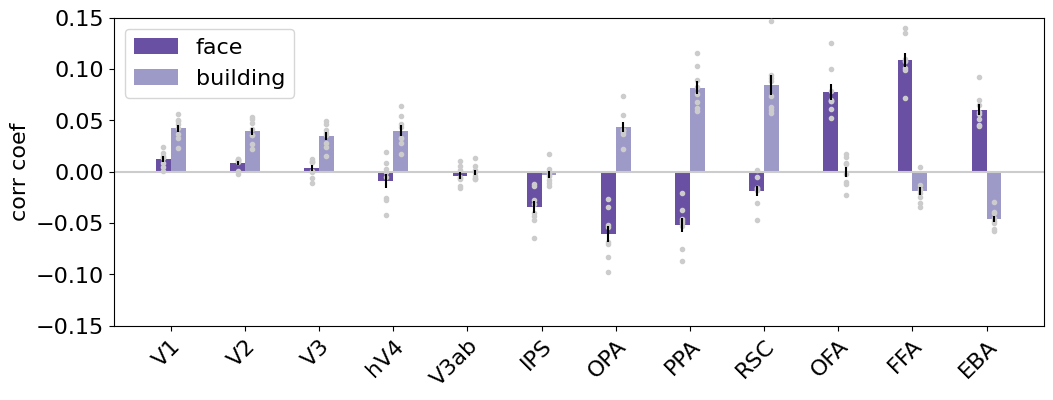

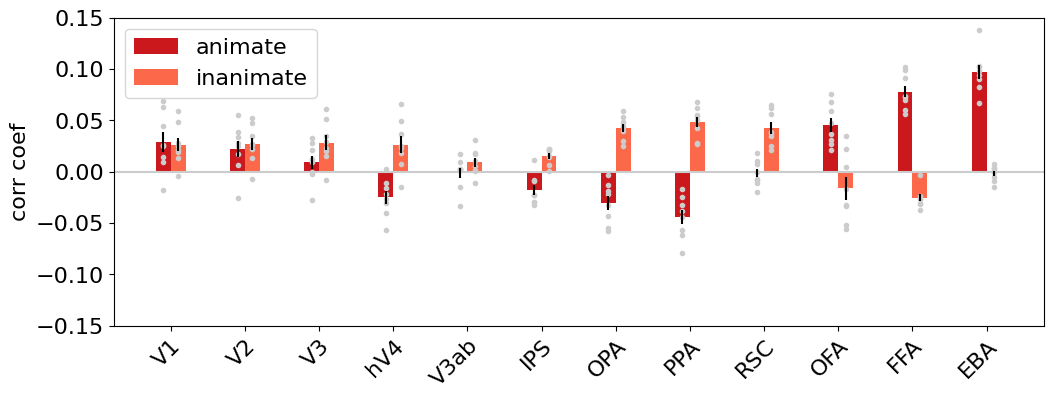

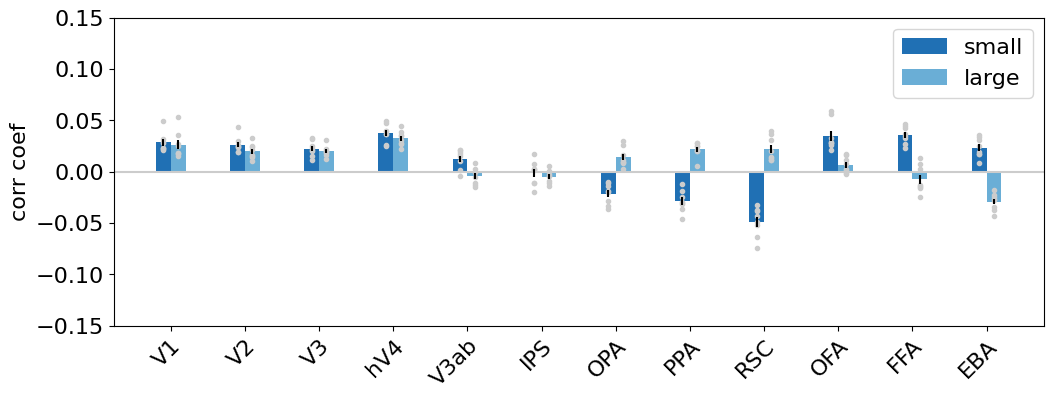

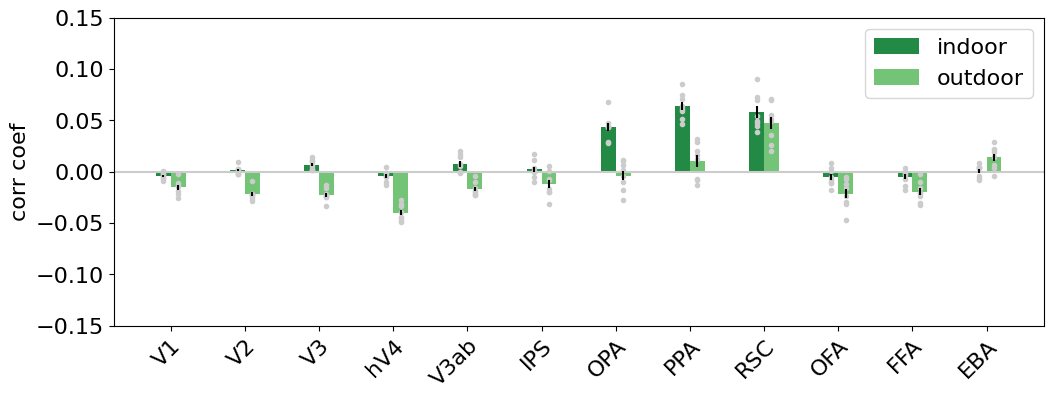

In [62]:
roi_mean_vals = np.zeros((n_rois, n_categ, n_subjects))

for si in range(n_subjects):

    nc = noise_ceilings[si]
    vox2use = nc>nc_thresh
    vals = partial_corrs[si]
    
    for ri in range(n_rois):

        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & vox2use
        roi_mean_vals[ri,:,si] = np.mean(vals[:,inds_this_roi], axis=1)

mean_vals = np.mean(roi_mean_vals, axis=2)
sem_vals = np.std(roi_mean_vals, axis=2)/np.sqrt(n_subjects)

legend_separate = True
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

for axes_plot in [[0,1],[2,3],[4,5],[6,7]]:
 
    bw = 0.2;
    space = (1 - (bw*len(axes_plot)))/2
                  
    point_data = np.moveaxis(roi_mean_vals[:,axes_plot,:], [0,1,2], [1,2,0])
    print(np.min(point_data), np.max(point_data))
    fh = plot_utils.plot_multi_bars(mean_data=mean_vals[:,axes_plot], err_data=sem_vals[:,axes_plot], \
                                    point_data = point_data, \
                                    colors=colors[axes_plot,:], space=space, \
                xticklabels=roi_names, ylabel='corr coef', \
                ylim=[-0.15, 0.15], horizontal_line_pos=0,\
                legend_labels=np.array(categ_names)[axes_plot], \
                legend_overlaid=True, legend_separate=False, \
                fig_size=(12,4))

    fn2save = os.path.join(default_paths.fig_path, \
                           'categ_selectivity_%s-%s.pdf'%(categ_names[axes_plot[0]], \
                                                          categ_names[axes_plot[1]]))
    print(fn2save)
    plt.savefig(fn2save)

In [50]:
roi_mean_vals.shape

(12, 4, 8)

#### Use PyCortex to make surface plots

In [11]:
from plotting import pycortex_plot_utils
volumes = {}
out = [load_fits.load_fit_results(ss, fitting_type,n_from_end=0,verbose=False) for ss in subjects]

mm=0;
nc_thresh = 0.01

for si, ss in zip([0],subjects[[0]]):
    
# for si, ss in enumerate(subjects):

    nc = noise_ceilings[si]
    vox2plot = nc>nc_thresh
 
    vals_partial = copy.deepcopy(partial_corrs[si])
   
    names = []
    maps = []
    cmaps = []
    mins = []
    maxes = []
            
    for cc in range(n_categ):
        
        names += ['S%d: %s partial'%(ss, categ_names[cc])]
        maps += [vals_partial[cc,:]]
        cmaps += ['RdBu']
        mins += [-0.5]
        maxes += [0.5]
        
    for gg in range(n_sem_groups):
        
        names += ['S%d: top %s vox'%(ss, sem_group_names[gg])]
        maps += [sem_groups[si][:,gg].astype(float)]
        cmaps += ['Blues']
        mins += [-0.1]
        maxes += [1.1]
      
    voxel_mask = out[si]['voxel_mask']
    nii_shape = out[si]['brain_nii_shape']
    mask_3d = np.reshape(voxel_mask, nii_shape, order='C')

    vol_ss = pycortex_plot_utils.maps_to_volumes(ss, maps, names, \
                         cmaps=cmaps, mins=mins, maxes=maxes, \
                         voxel_mask=voxel_mask, nii_shape=nii_shape, mask_3d=mask_3d, \
                         vox2plot=vox2plot)

    volumes.update(vol_ss)
    

In [12]:
viewer = pycortex_plot_utils.plot_with_overlays(volumes, title='Semantic selectivity partial corrs', \
                                                port = 64447, \
                                                labels_on=False, recache=False, \
                                                overlay_type = 'overlays')

using overlays from /user_data/mmhender/pycortex_db/subj01/overlays.svg
navigate browser to: 127.0.0.1:64447
Started server on port 64447


0.9727935961090283
0.9717180244829042
0.943752812359382
0.9344060854300761
0.9770443988333153
0.978693967902601
0.9658270106221548
0.8503915597128562


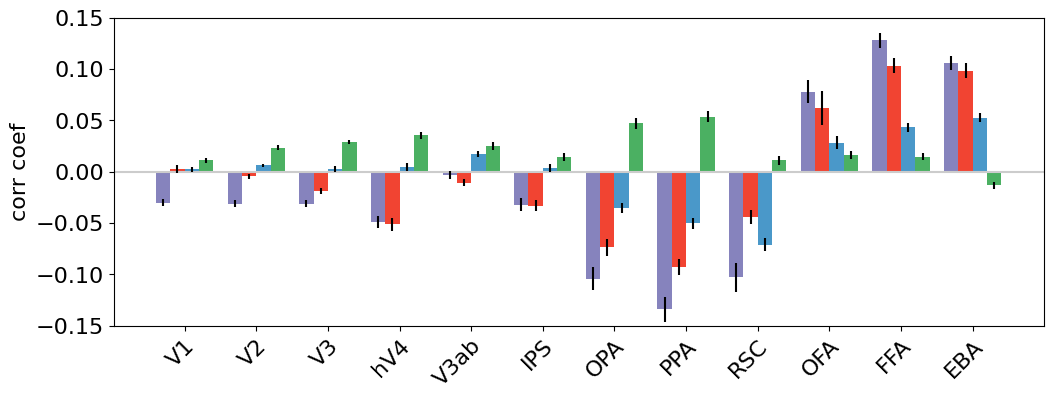

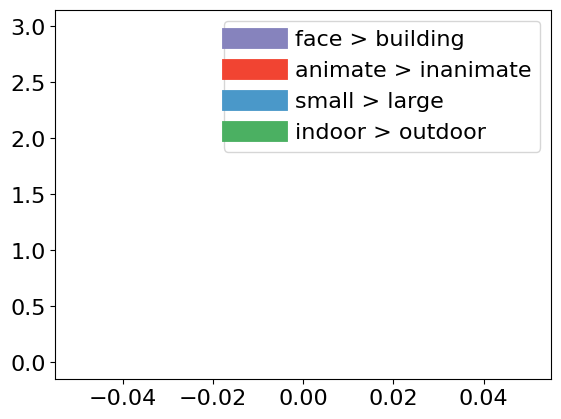

In [59]:
roi_mean_vals = np.zeros((n_rois, n_discrim_types, n_subjects))

for si in range(n_subjects):

    nc = noise_ceilings[si]
    vox2use = nc>nc_thresh
    vals = partial_corr_diffs[si]
    
    print(np.mean(vox2use))
    
    for ri in range(n_rois):

        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & vox2use
        roi_mean_vals[ri,:,si] = np.mean(vals[:,inds_this_roi], axis=1)

mean_vals = np.mean(roi_mean_vals, axis=2)
sem_vals = np.std(roi_mean_vals, axis=2)/np.sqrt(n_subjects)

legend_separate = True
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

for axes_plot in [[0,1,2,3]]:
 
    bw = 0.2;
    space = (1 - (bw*len(axes_plot)))/2
                  
    fh = plot_utils.plot_multi_bars(mean_data=mean_vals[:,axes_plot], err_data=sem_vals[:,axes_plot], \
                                    # point_data = np.moveaxis(roi_mean_vals[:,axes_plot,:], [0,1,2], [1,2,0]), \
                                    colors=colors_categ[axes_plot,:], space=space, \
                xticklabels=roi_names, ylabel='corr coef', \
                ylim=[-0.15, 0.15], horizontal_line_pos=0,\
                legend_labels=np.array(signed_names)[axes_plot], \
                legend_overlaid=False, legend_separate=True, \
                fig_size=(12,4))

# fn2save = os.path.join(default_paths.fig_path, 'Semantic_selectivity_signed_ROIavg.pdf')
# plt.savefig(fn2save)